Data: https://www.kaggle.com/datasets/chiyucheng/flight-parquet?resource=download

In [30]:
zhawaccount = 'foellsim'

In [31]:
import sparky
import pyspark
import time
#import slash
from pyspark.sql.functions import col
import pyspark.sql
sc = sparky.connect(f"sparknotebook-{zhawaccount}", 2)
sc.setLogLevel("OFF")
spark = pyspark.sql.SparkSession.builder.getOrCreate()

import pandas as pd
pd.set_option('display.max_columns', None)

Attached to Sparky cluster context from sparky-collab as sparknotebook-foellsim.
Requested 2 cores; real number might be less.


In [32]:
# Pfad zum Verzeichnis, das die Parquet-Dateien enthält
pfad = "data"

# Lese alle Parquet-Dateien aus dem Verzeichnis und wähle nur bestimmte Spalten aus
spalten = [
    "Year", "Month", "DayofMonth", "DayOfWeek", "FlightDate",
    "Reporting_Airline", "Origin", "Dest", "CRSDepTime", "DepTime",
    "DepDelay", "DepDelayMinutes", "DepDel15", "DepartureDelayGroups",
    "CRSArrTime", "ArrTime", "ArrDelay", "ArrDelayMinutes", "ArrDel15",
    "Cancelled", "CancellationCode", "Diverted", "CRSElapsedTime",
    "ActualElapsedTime", "AirTime", "Distance"
]

df_raw = spark.read.parquet(pfad).select(spalten)

# Zeige die ersten paar Zeilen der Daten
df_raw.limit(5).toPandas()



,Year,Month,DayofMonth,DayOfWeek,FlightDate,Reporting_Airline,Origin,Dest,CRSDepTime,DepTime,DepDelay,DepDelayMinutes,DepDel15,DepartureDelayGroups,CRSArrTime,ArrTime,ArrDelay,ArrDelayMinutes,ArrDel15,Cancelled,CancellationCode,Diverted,CRSElapsedTime,ActualElapsedTime,AirTime,Distance
0,2022,1,14,5,2022-01-14,YX,CMH,DCA,1224,1221,-3.00,0.00,0.00,-1,1352,1356,4.00,4.00,0.00,0.00,None,0.00,88.00,95.00,63.00,323.00
1,2022,1,15,6,2022-01-15,YX,CMH,DCA,1224,1214,-10.00,0.00,0.00,-1,1352,1328,-24.00,0.00,0.00,0.00,None,0.00,88.00,74.00,50.00,323.00
2,2022,1,16,7,2022-01-16,YX,CMH,DCA,1224,1218,-6.00,0.00,0.00,-1,1352,1339,-13.00,0.00,0.00,0.00,None,0.00,88.00,81.00,53.00,323.00
3,2022,1,17,1,2022-01-17,YX,CMH,DCA,1224,1217,-7.00,0.00,0.00,-1,1352,1401,9.00,9.00,0.00,0.00,None,0.00,88.00,104.00,56.00,323.00
4,2022,1,18,2,2022-01-18,YX,CMH,DCA,1224,1218,-6.00,0.00,0.00,-1,1352,1323,-29.00,0.00,0.00,0.00,None,0.00,88.00,65.00,48.00,323.00


In [33]:
df_raw.schema

StructType([StructField('Year', StringType(), True), StructField('Month', StringType(), True), StructField('DayofMonth', StringType(), True), StructField('DayOfWeek', StringType(), True), StructField('FlightDate', StringType(), True), StructField('Reporting_Airline', StringType(), True), StructField('Origin', StringType(), True), StructField('Dest', StringType(), True), StructField('CRSDepTime', StringType(), True), StructField('DepTime', StringType(), True), StructField('DepDelay', StringType(), True), StructField('DepDelayMinutes', StringType(), True), StructField('DepDel15', StringType(), True), StructField('DepartureDelayGroups', StringType(), True), StructField('CRSArrTime', StringType(), True), StructField('ArrTime', StringType(), True), StructField('ArrDelay', StringType(), True), StructField('ArrDelayMinutes', StringType(), True), StructField('ArrDel15', StringType(), True), StructField('Cancelled', StringType(), True), StructField('CancellationCode', StringType(), True), Struc

In [34]:
df = df_raw\
       .withColumn("DepDelayMinutes", col("DepDelayMinutes").cast("float"))\
       .withColumn("ArrDelayMinutes", col("ArrDelayMinutes").cast("float"))\
       .withColumn("DayOfWeek", col("DayOfWeek").cast("int"))\
       .withColumn("AirTime", col("AirTime").cast("float"))\
       .withColumn("Cancelled", col("Cancelled").cast("int") == 1)\
      

In [35]:
df.createOrReplaceTempView("flights")

In [36]:
%%time
ergebnis1 = spark.sql("""
    SELECT
      Reporting_Airline,
      COUNT(*) AS num_flights,
      COUNT(CASE WHEN DepDelayMinutes > 0.0 THEN 1 END) AS num_flights_with_delay,
      AVG(DepDelayMinutes) AS avg_dep_delay,
      percentile_approx(DepDelayMinutes, 0.90) as p90_dep_delay
    FROM flights
    GROUP BY Reporting_Airline
    ORDER BY avg_dep_delay DESC
""")
ergebnis1.toPandas()


CPU times: user 24.2 ms, sys: 1.72 ms, total: 25.9 ms
Wall time: 8.29 s


,Reporting_Airline,num_flights,num_flights_with_delay,avg_dep_delay,p90_dep_delay
0,B6,273058,128314,26.434079,82.0
1,F9,155482,72339,24.394282,71.0
2,G4,116877,53631,22.275866,63.0
3,YV,114779,35642,19.147114,52.0
4,AA,874145,327182,18.003319,49.0
5,NK,232400,90219,17.150878,51.0
6,WN,1307149,713906,15.842449,45.0
7,UA,626473,242658,15.344194,42.0
8,OH,214450,61345,14.308439,40.0
9,OO,733576,194764,14.177725,33.0


In [37]:
%%time
ergebnis2 = spark.sql("""
    SELECT
      Dest,
      COUNT(*) AS num_flights,
      COUNT(CASE WHEN ArrDelayMinutes > 0.0 THEN 1 END) AS num_flights_with_delay,
      AVG(ArrDelayMinutes) as avg_arr_delay,
      percentile_approx(ArrDelayMinutes, 0.90) as p90_arr_delay
    FROM flights
    GROUP BY Dest
    HAVING num_flights > 100
    ORDER BY avg_arr_delay DESC
""")
ergebnis2.limit(20).toPandas()


CPU times: user 17.9 ms, sys: 1.14 ms, total: 19.1 ms
Wall time: 8.29 s


,Dest,num_flights,num_flights_with_delay,avg_arr_delay,p90_arr_delay
0,PGD,6152,3863,36.486510,98.0
1,BQN,2398,1361,31.032702,92.0
2,BIH,325,149,30.433121,90.0
3,ASE,6464,2815,28.337271,78.0
4,MQT,1100,386,27.729446,54.0
5,DIK,116,18,27.471910,32.0
6,SFB,9166,5049,27.385325,73.0
7,PIE,7829,4165,26.676866,76.0
8,SHD,606,145,25.903879,63.0
9,PSE,863,416,25.743276,85.0


In [38]:
%%time
ergebnis3 = spark.sql("""
    SELECT
      CASE DayOfWeek
        WHEN 1 THEN 'Monday'
        WHEN 2 THEN 'Tuesday'
        WHEN 3 THEN 'Wednesday'
        WHEN 4 THEN 'Thursday'
        WHEN 5 THEN 'Friday'
        WHEN 6 THEN 'Saturday'
        WHEN 7 THEN 'Sunday'
      END AS weekday,
      COUNT(*) as flight_count
    FROM flights
    GROUP BY DayOfWeek
    ORDER BY DayOfWeek ASC
""")
ergebnis3.toPandas()


CPU times: user 13.1 ms, sys: 3.01 ms, total: 16.1 ms
Wall time: 1.34 s


,weekday,flight_count
0,Monday,997219
1,Tuesday,934061
2,Wednesday,946037
3,Thursday,995372
4,Friday,1001705
5,Saturday,876949
6,Sunday,977782


In [39]:
%%time
ergebnis4 = spark.sql("""
    SELECT
      Reporting_Airline,
      AVG(AirTime) as avg_air_time,
      percentile_approx(AirTime, 0.90) as p90_air_time
    FROM flights
    GROUP BY Reporting_Airline
    ORDER BY avg_air_time DESC
""")
ergebnis4.toPandas()


CPU times: user 14.4 ms, sys: 5.19 ms, total: 19.6 ms
Wall time: 5.48 s


,Reporting_Airline,avg_air_time,p90_air_time
0,AS,176.912353,319.0
1,B6,153.860728,294.0
2,UA,152.281961,277.0
3,NK,135.156529,217.0
4,AA,132.762647,239.0
5,F9,131.758813,210.0
6,DL,125.031349,236.0
7,HA,121.802317,324.0
8,G4,121.712624,172.0
9,WN,99.861908,170.0


In [40]:
%%time
ergebnis5 = spark.sql("""
    SELECT
      CancellationCode,
      COUNT(*) as cancelled_flights
    FROM flights
    WHERE Cancelled = True
    GROUP BY CancellationCode
    ORDER BY cancelled_flights DESC
""")
ergebnis5.toPandas()


CPU times: user 7.69 ms, sys: 7.83 ms, total: 15.5 ms
Wall time: 1.19 s


,CancellationCode,cancelled_flights
0,B,93013
1,A,71780
2,C,15469
3,D,1024


In [41]:
import matplotlib.pyplot as plt
import pandas as pd

# Funktion zur Visualisierung der Ergebnisse
def plot_results(ergebnis, x_label, y_label, title):
    ergebnis_pd = ergebnis.toPandas()
    plt.bar(ergebnis_pd[x_label], ergebnis_pd[y_label])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

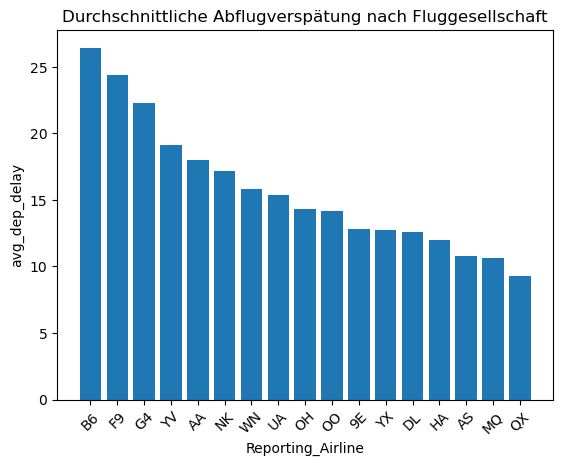

In [42]:
plot_results(ergebnis1, 'Reporting_Airline', 'avg_dep_delay', 'Durchschnittliche Abflugverspätung nach Fluggesellschaft')

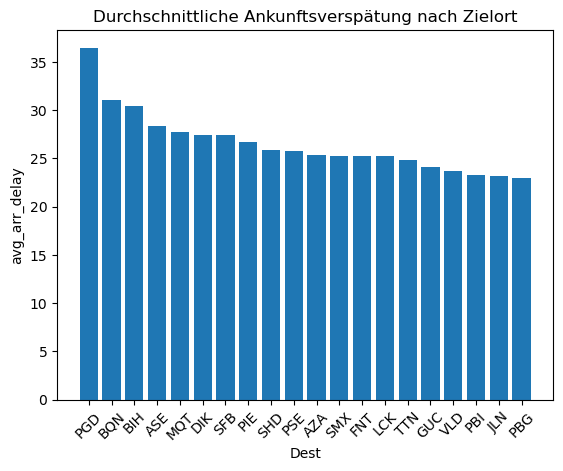

In [43]:
plot_results(ergebnis2.limit(20), 'Dest', 'avg_arr_delay', 'Durchschnittliche Ankunftsverspätung nach Zielort')

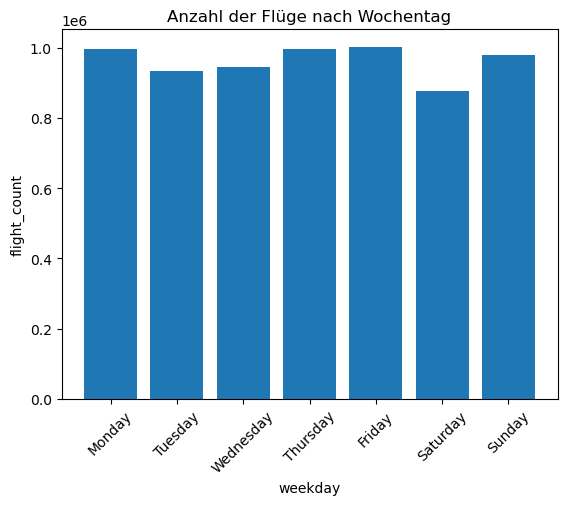

In [44]:
plot_results(ergebnis3, 'weekday', 'flight_count', 'Anzahl der Flüge nach Wochentag')

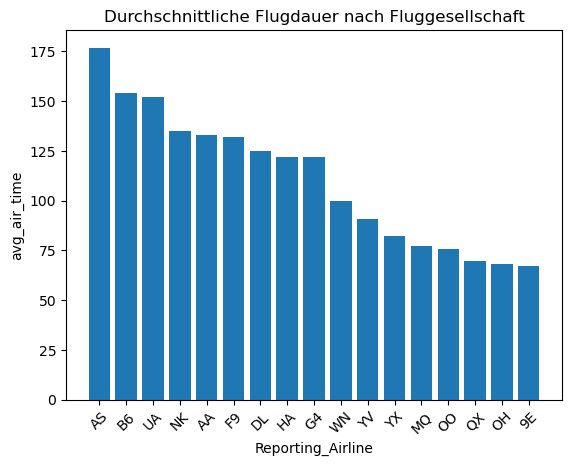

In [45]:
plot_results(ergebnis4, 'Reporting_Airline', 'avg_air_time', 'Durchschnittliche Flugdauer nach Fluggesellschaft')

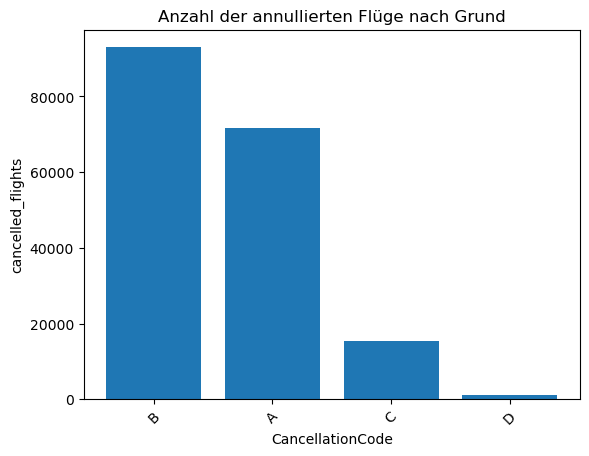

In [46]:
plot_results(ergebnis5, 'CancellationCode', 'cancelled_flights', 'Anzahl der annullierten Flüge nach Grund')

# Join with Airport data from CSV

In [47]:
df_airports = spark.read.csv(
    "airport_lookup.csv",  # Replace with actual path
    header=True,                   # Use first row as column names
    inferSchema=True               # Try to infer data types
)

In [48]:
df_airports.limit(10).toPandas()

,AIRPORT_SEQ_ID,AIRPORT_ID,AIRPORT,DISPLAY_AIRPORT_NAME,DISPLAY_AIRPORT_CITY_NAME_FULL,AIRPORT_COUNTRY_NAME,AIRPORT_COUNTRY_CODE_ISO,AIRPORT_STATE_NAME,AIRPORT_STATE_CODE,AIRPORT_STATE_FIPS,CITY_MARKET_ID,DISPLAY_CITY_MARKET_NAME_FULL,CITY_MARKET_WAC,LAT_DEGREES,LATITUDE,LON_DEGREES,LONGITUDE
0,1000101,10001,01A,Afognak Lake Airport,"Afognak Lake, AK",United States,US,Alaska,AK,2,30001,"Afognak Lake, AK",1,58,58.109444,152,-152.906667
1,1000301,10003,03A,Bear Creek Mining Strip,"Granite Mountain, AK",United States,US,Alaska,AK,2,30003,"Granite Mountain, AK",1,65,65.548056,161,-161.071667
2,1000401,10004,04A,Lik Mining Camp,"Lik, AK",United States,US,Alaska,AK,2,30004,"Lik, AK",1,68,68.083333,163,-163.166667
3,1000501,10005,05A,Little Squaw Airport,"Little Squaw, AK",United States,US,Alaska,AK,2,30005,"Little Squaw, AK",1,67,67.570000,148,-148.183889
4,1000601,10006,06A,Kizhuyak Bay,"Kizhuyak, AK",United States,US,Alaska,AK,2,30006,"Kizhuyak, AK",1,57,57.745278,152,-152.882778
5,1000701,10007,07A,Klawock Seaplane Base,"Klawock, AK",United States,US,Alaska,AK,2,30007,"Klawock, AK",1,55,55.554722,133,-133.101667
6,1000801,10008,08A,Elizabeth Island Airport,"Elizabeth Island, AK",United States,US,Alaska,AK,2,30008,"Elizabeth Island, AK",1,59,59.156944,151,-151.829167
7,1000901,10009,09A,Augustin Island,"Homer, AK",United States,US,Alaska,AK,2,30009,"Homer, AK",1,59,59.362778,153,-153.430556
8,1001001,10010,1B1,Columbia County,"Hudson, NY",United States,US,New York,NY,36,30010,"Hudson, NY",22,42,42.288889,73,-73.710278
9,1001002,10010,1B1,Columbia County,"Hudson, NY",United States,US,New York,NY,36,30010,"Hudson, NY",22,42,42.291389,73,-73.710278


In [49]:
df_airports.createOrReplaceTempView("airports")

In [50]:
%%time
ergebnis6 = spark.sql("""
    SELECT
      a.AIRPORT_STATE_NAME,
      COUNT(DISTINCT Dest) AS num_airports,
      COUNT(*) AS num_flights,
      COUNT(CASE WHEN ArrDelayMinutes > 0.0 THEN 1 END) AS num_flights_with_delay,
      AVG(ArrDelayMinutes) as avg_arr_delay
    FROM flights f
    JOIN airports a
    ON f.Dest = a.AIRPORT
    WHERE a.AIRPORT_STATE_NAME IS NOT NULL
    GROUP BY a.AIRPORT_STATE_NAME
    ORDER BY avg_arr_delay DESC
""")
ergebnis6.limit(20).toPandas()

CPU times: user 12.4 ms, sys: 8.23 ms, total: 20.6 ms
Wall time: 7.16 s


,AIRPORT_STATE_NAME,num_airports,num_flights,num_flights_with_delay,avg_arr_delay
0,Delaware,1,94,54,29.619048
1,Puerto Rico,3,156400,71520,21.258732
2,New Jersey,3,277224,114574,20.924397
3,Florida,19,1816917,766891,19.410209
4,New York,15,1674915,633976,19.159238
5,Massachusetts,5,292608,106655,18.199465
6,Connecticut,1,164402,67389,17.548108
7,Maine,2,63778,23773,16.876499
8,Indiana,4,238938,91024,16.597709
9,Pennsylvania,9,578572,202171,16.525156


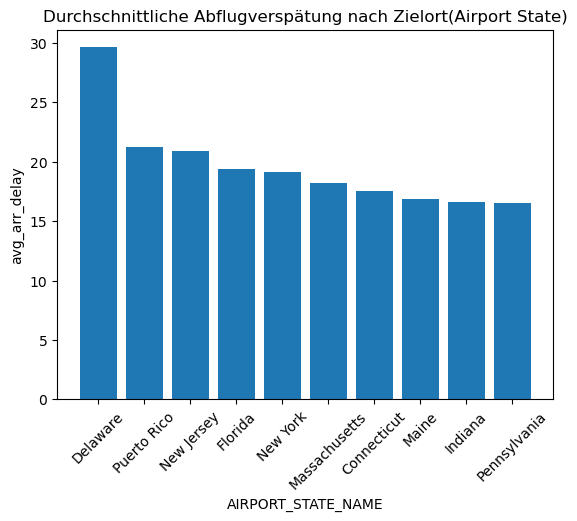

In [51]:
plot_results(ergebnis6.limit(10), 'AIRPORT_STATE_NAME', 'avg_arr_delay', 'Durchschnittliche Abflugverspätung nach Zielort(Airport State)')

## Time computation for join

In [52]:
start = time.time()
ergebnis6.show()
end = time.time()
elapsed_6 = end - start

print(f"Elapsed time: {elapsed_6:.2f} seconds")

+------------------+------------+-----------+----------------------+------------------+
|AIRPORT_STATE_NAME|num_airports|num_flights|num_flights_with_delay|     avg_arr_delay|
+------------------+------------+-----------+----------------------+------------------+
|          Delaware|           1|         94|                    54| 29.61904761904762|
|       Puerto Rico|           3|     156400|                 71520|21.258731711159392|
|        New Jersey|           3|     277224|                114574| 20.92439697861756|
|           Florida|          19|    1816917|                766891|19.410209221066257|
|          New York|          15|    1674915|                633976| 19.15923752617429|
|     Massachusetts|           5|     292608|                106655| 18.19946537903846|
|       Connecticut|           1|     164402|                 67389| 17.54810829879178|
|             Maine|           2|      63778|                 23773|16.876499436675726|
|           Indiana|           4

In [29]:
#spark.stop()